<a href="https://colab.research.google.com/github/blackbaba980/GameOfThronesPredictions/blob/main/code/GameOfThronesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils.convert import from_networkx



import math
import time

import torch

from torch.nn.parameter import Parameter
from torch.nn.modules.module import Module
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

random_seed = 7
#set the random seeds 
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

epochs = 200
lr = 0.01
weight_decay = 5e-4
hidden_units = 16
dropout = 0.5

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset Preprocessing


In [96]:
#per season adjaceny matrix, features of every node


def load_data(season_no):

  #read the edge and node files
  dir = "./../data/nodes_edges/"
  edge_file = dir + "got-s" + str(season_no) + "-edges.csv"
  node_file = dir + "got-s" + str(season_no) + "-m-nodes.csv"

  edges = pd.read_csv(edge_file)
  nodes = pd.read_csv(node_file)
  
  
  #only get those edges where the nodes are present
  node_ids = nodes['CHARACTERS ID']
  node_ids_reverse = node_ids.to_dict()
  node_ids = {v: k for k, v in node_ids_reverse.items()}
  
  #remove unnecessary columns
  features = nodes.drop(['CHARACTERS ID'], axis=1)
  features = torch.from_numpy(features.to_numpy().astype(np.float32))
  edges = edges.drop(['Season'], axis=1)
  
  #Adjacency matrix
  gr = nx.Graph()
  adj = np.zeros( (len(node_ids),len(node_ids)) )

  for i in range(len(edges)):
    if edges.iloc[i]['Source'] in node_ids and edges.iloc[i]['Target'] in node_ids:
      src_index = node_ids[edges.iloc[i]['Source']]
      dst_index = node_ids[edges.iloc[i]['Target']]
      gr.add_edge(src_index, dst_index, weight=edges.iloc[i]['Weight'])
      adj[src_index][dst_index] = edges.iloc[i]['Weight']
      adj[dst_index][src_index] = edges.iloc[i]['Weight']


  adj = torch.from_numpy(adj.astype(np.float32))
  print("adj max is {}".format(adj.max()))

  return features, adj, gr, node_ids

  #return torch.from_numpy(features.to_numpy()), torch.from_numpy(adj), gr, node_ids
  #return nodes, edges



#features, adj, graph, node_ids = load_data(1)



# Per Season Graph

In [97]:
per_season_graph = []
per_season_adj = []
per_season_nodes = []
per_season_features = []
per_season_pyg_graph = []
per_season_normalized_adj = []

def normalize_adj(adj):
    return adj / adj.sum()

for i in range(1,9):
    features, adj, graph, node_ids = load_data(i)
    per_season_graph.append(graph)
    per_season_adj.append(adj)
    per_season_nodes.append(node_ids)
    per_season_features.append(features)
    per_season_pyg_graph.append(from_networkx(graph))
    per_season_normalized_adj.append(normalize_adj(adj))
    

adj max is 192.0
adj max is 177.0
adj max is 159.0
adj max is 147.0
adj max is 141.0
adj max is 151.0
adj max is 179.0
adj max is 194.0


# New Model

# Generative Model

In [98]:
class GraphConvolution(Module):
  def __init__(self, in_features, out_features, bias=True):
    super(GraphConvolution, self).__init__()
    self.in_features = in_features
    self.out_features = out_features
    self.weight = Parameter(torch.FloatTensor(in_features, out_features))
    if bias:
        self.bias = Parameter(torch.FloatTensor(out_features))
    else:
        self.register_parameter('bias', None)
    self.reset_parameters()

  def reset_parameters(self):
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    if self.bias is not None:
        self.bias.data.uniform_(-stdv, stdv)

  def forward(self, input, adj):
    support = torch.mm(input, self.weight)
    output = torch.mm(adj, support)
    if self.bias is not None:
        return output + self.bias
    else:
        return output

  def __repr__(self):
    return self.__class__.__name__ + ' (' \
            + str(self.in_features) + ' -> ' \
            + str(self.out_features) + ')'

In [545]:
class Encoder(nn.Module):
  def __init__(self, nfeat, nhid, nclass):
    super(Encoder, self).__init__()

    self.conv = GraphConvolution(nfeat, nhid)
    self.mean_finder = GraphConvolution(nhid, nclass)
    self.logstd_finder = GraphConvolution(nhid, nclass)    

    
    self.embeddings = []

  def forward(self, x, adj, save_embeddings = False):
    x = F.relu(self.conv(x, adj))
    self.mean = self.mean_finder(x, adj)
    self.logstd = torch.exp(self.logstd_finder(x, adj))
    
    gaussian_noise = torch.randn_like(x)
    sampled_z = gaussian_noise*self.logstd + self.mean
    return sampled_z

  def kl_div(self):
    kl = -0.5 * torch.mean(
            torch.sum(1 + 2 * self.logstd - self.mean**2 - self.logstd.exp()**2, dim=1))
    return kl

  def kl_loss(self):

    MAX_LOGSTD = 10
    self.logstd =  self.logstd.clamp(max=MAX_LOGSTD)
    kl_div = -0.5 * torch.mean(torch.sum(1 + 2 * self.logstd - self.mean**2 - self.logstd.exp()**2, dim=1))

    # Limit numeric errors
    kl_div = kl_div.clamp(max=1000)
    return kl_div
    

In [546]:
from torch_geometric.nn.models import InnerProductDecoder, VGAE

# class Decoder(nn.Module):
#   def __init__(self, latent_dim, output_dim):
#     super(Decoder, self).__init__()
#     #self.decoder = InnerProductDecoder()

#     self.linear1 = nn.Linear(latent_dim, latent_dim)
#     self.ll = nn.ModuleList()
#     self.t = 42
#     for i in range(self.t):
#       self.ll.append(nn.Linear(latent_dim, output_dim))

#     self.weights = 

#     #42 x 20 => 42 x 20 => (42 * 200) -> 42 of them
  

#   def forward(self, x):
   
#     x = F.relu(self.linear1(x))


#     outputs = []

#     for i in range(self.t):
#       a = F.softmax(self.ll[i](x), dim=1)
#       if torch.any(a.isnan()):
#         print("Found nan*************************")
        
#       outputs.append(a)

#     #1728 * 200 nodes
#     return outputs


class Decoder(nn.Module):
  def __init__(self, latent_dim, output_dim):
    super(Decoder, self).__init__()
    #self.decoder = InnerProductDecoder()

    self.linear1 = nn.Linear(latent_dim, latent_dim)
    self.ll = nn.ModuleList()
    self.t = int( ( (42 * 42) - 42 ) / 2)


    #node attributes
    self.node_death = nn.Linear(latent_dim, 1)
    self.node_king  = nn.Linear(latent_dim, 1)
    self.node_war   = nn.Linear(latent_dim, 1)

    #adjacency 
    self.adjacency_finder = nn.Linear(latent_dim*42, self.t)

    #edge type (lets put them into 10 groups)
    
    self.edge_layer_1 = nn.Linear(42*20, self.t)
    self.edge_layer_2 = nn.Linear(1, 10)
    #flattent it



    #42 x 20 => 42 x 20 => (42 * 200) -> 42 of them
  

  def decode(self, x):
    x = F.relu(self.linear1(x))
    death = F.sigmoid(self.node_death(x))
    war = F.sigmoid(self.node_war(x))
    king = F.sigmoid(self.node_king(x))

    #adjacency
    adj = F.sigmoid(self.adjacency_finder(torch.flatten(x)))

    #edge type
    y = torch.flatten(x)
    y = F.relu(self.edge_layer_1(y))
    y = y.reshape(self.t, 1)
    y = F.softmax(self.edge_layer_2(y))

    return death, war, king, adj, y





In [548]:
from torch_geometric.utils import negative_sampling, remove_self_loops, add_self_loops

class DeepVGAE(nn.Module):
  def __init__(self):
    super(DeepVGAE, self).__init__()
    self.encoder = Encoder(nfeat=10, nhid=20, nclass=20)
    self.decoder = Decoder(20,200)


  def do_it(self, x, adj):
    z = self.encoder(x, adj)
    self.kl_loss = self.encoder.kl_div()
    death, war, king, adj, y = self.decoder.decode(z)
    return death, war, king, adj, y


In [603]:
for i in range(0,200,20):
    print(i)
list(range(20))

0
20
40
60
80
100
120
140
160
180


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [604]:

def get_class(up):
    return int(up / 20)
    

def get_the_upper(actual_adj):
    upper_size = int( ( (42 * 42) - 42 ) / 2)
    uppers = torch.zeros((upper_size, 1))


    k = 0
    for i in range(42-1):
        for j in range(i+1, 42):
            uppers[k][0] = actual_adj[i][j]
            k += 1

    for i in range(upper_size):
        uppers[i][0] = get_class(uppers[i])
    return uppers

def losses(death, war, king, adj, y, actual_features, actual_adj):

    l1 = torch.binary_cross_entropy_with_logits(king, actual_features[:,7].reshape(42,1)).sum() / 42
    l2 = torch.binary_cross_entropy_with_logits(death, actual_features[:,8].reshape(42,1)).sum() / 42
    l3 = torch.binary_cross_entropy_with_logits(war, actual_features[:,9].reshape(42,1)).sum() / 42



    uppers = get_the_upper(actual_adj)
    upper_size = int( ( (42 * 42) - 42 ) / 2)

    w1 = torch.autograd.Variable(upper_size/sum(torch.where(uppers > 0, 1.0, 0.0)))
    w2 = torch.autograd.Variable(upper_size/sum(uppers))
    bce = torch.nn.BCEWithLogitsLoss(pos_weight=w1)
    l4 = bce(adj.reshape(adj.shape[0],1), torch.where(uppers > 0, 1.0, 0.0)).sum()  / upper_size

    CEL = torch.nn.CrossEntropyLoss() 
    l5 = CEL(adj.reshape(adj.shape[0],1), uppers).sum() / upper_size

    return l1+l2+l3+l4+l5


def get_accuracy_adj(predicted, actual_adj):
    targets = get_the_upper(actual_adj)



In [605]:
model = DeepVGAE()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
    

In [608]:
#One training step
from tqdm import tqdm


#Give the input graph to the VGAE
overall_loss = []
reconstruction_loss = []
kl_loss = []

EPOCHS = 600
model.train()
for epoch in tqdm(range(EPOCHS)):
    for i in range(6):

        optimizer.zero_grad()
        #Inference
        death, war, king, adj, y = model.do_it(per_season_features[i], per_season_normalized_adj[i])

        
        
        #find reconstruction loss
        loss = losses(death, war, king, adj, y,per_season_features[i+1], per_season_adj[i+1])
        reconstruction_loss.append(loss.clone().detach().numpy())

        #find kl loss
        kl_divergence = 0.2 * model.kl_loss
        
        kl_loss.append(kl_divergence.clone().detach().numpy())

        #add recon_loss + kl_loss
        loss += kl_divergence
        overall_loss.append(loss.clone().detach().numpy())


        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()


  0%|          | 0/600 [00:00<?, ?it/s]/var/folders/dd/s4g963nd5jq4rd0szl1w4_hr0000gn/T/ipykernel_9575/1083026161.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(self.edge_layer_2(y))
100%|██████████| 600/600 [01:38<00:00,  6.08it/s]


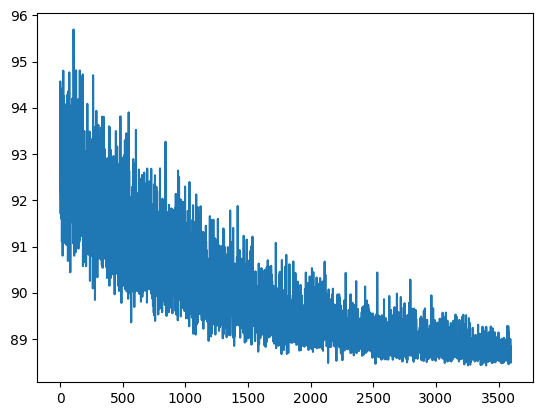

In [609]:
plt.plot(range(EPOCHS * 6), reconstruction_loss)

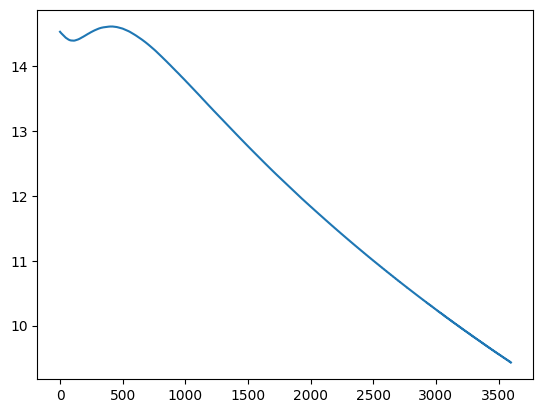

In [557]:
plt.plot(range(EPOCHS * 6), kl_loss)

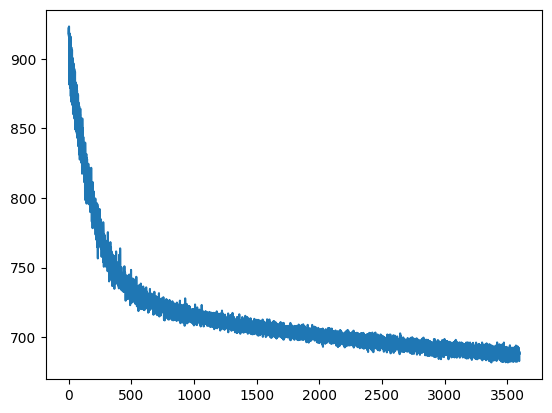

In [558]:
plt.plot(range(EPOCHS * 6), overall_loss)

In [429]:
def draw_the_graph_output(model_output):
    # adj = np.zeros((42,42))
    # k = 0
    # gr = nx.Graph()
    # for i in range(42-1):
    #   for j in range(i+1,42):
    #     qx = model_output[k]
    #     w = torch.argmax(qx)
    #     adj[i][j] = w
    #     adj[j][i] = w
    #     if w != 0:
    #       gr.add_edge(i, j, weight=w)
    #     k += 1

    gr = nx.Graph()
    adj = np.zeros((42,42))

    for i, out in enumerate(model_output):
      print(out)
      argmaxs = torch.argmax(out, 1)
      adj[:,i] = argmaxs
    
    for i in range(42-1):
      for j in range(i+1,42):
        gr.add_edge(i,j, weight=adj[i,j])

    return gr, adj

def draw_the_graph(output):
  pass
  
            

In [533]:
death, war, king, adj, y = model.do_it(per_season_features[5], per_season_normalized_adj[5])


/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/var/folders/dd/s4g963nd5jq4rd0szl1w4_hr0000gn/T/ipykernel_9575/1083026161.py:79: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y = F.softmax(self.edge_layer_2(y))


In [535]:
death.max()

tensor(0.1579, grad_fn=<MaxBackward1>)

In [536]:
king.max()

tensor(0.1268, grad_fn=<MaxBackward1>)

In [537]:
war.max()

tensor(0.1241, grad_fn=<MaxBackward1>)

In [543]:
adj.shape

torch.Size([861])

In [431]:
for i in range(42):
    for j in range(42):
        print(adj[i,j], end=" ")
    print(" ")

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0  
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.

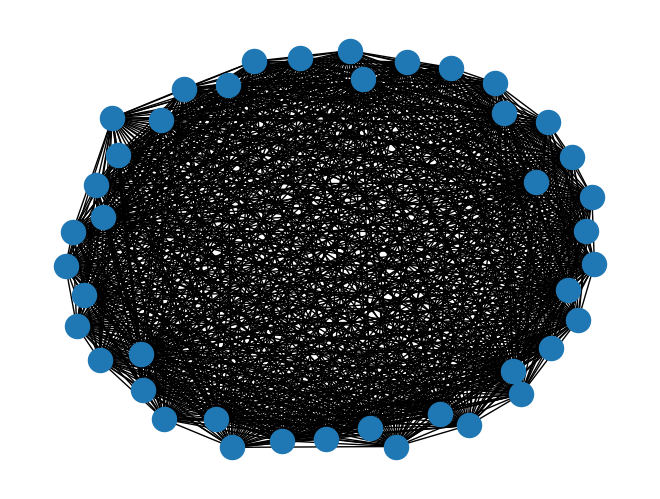

In [379]:
nx.draw(gr)

In [95]:
len(gr.edges())

861

# USING Autoencoders

In [230]:
class JustEncoder(nn.Module):
  def __init__(self, nfeat, nhid):
    super(JustEncoder, self).__init__()

    self.conv_1 = GraphConvolution(nfeat, nhid)
    self.conv_2 = GraphConvolution(nhid, nhid)
     

  def forward(self, x, adj, save_embeddings = False):
    x = F.relu(self.conv_1(x, adj))
    x = F.relu(self.conv_2(x, adj))
    return x


In [258]:
#42 x 10 -> 42x20 -> 42x20 -> decoder_edge = equal_number_of_edges
                              #decoder_nodes = equal_number_of_degree

class EdgesDecoder(nn.Module):

    def __init__(self, n_hidden, n_edges, n_nodes):
        super(EdgesDecoder, self).__init__()
        self.mlp1 = nn.Linear(n_hidden, n_nodes)

    def forward(self, x):
        return self.mlp1(x)

    def loss(self, output, actual, nodes_num):

        #use mean squared error
        k = 0
        lsum  = 0
        for i in range(nodes_num):
            for j in range(nodes_num):
                lsum += (output[i][j] - actual[i][j]) ** 2
                
        return (lsum / (nodes_num * nodes_num))



class FeaturesDecoder(nn.Module):
    def __init__(self, n_nodes, n_hidden):
        super(FeaturesDecoder, self).__init__()
        self.king = nn.Linear( n_hidden, 1)
        self.death = nn.Linear( n_hidden, 1)
        self.war = nn.Linear(n_hidden, 1)
        self.n_nodes = n_nodes



    def forward_all(self, x):
        king =  F.sigmoid(self.king(x))
        death = F.sigmoid(self.death(x))
        war = self.war(x)

        return king, death, war


    def loss(self, output, actual):
        l1 = nn.functional.binary_cross_entropy(output[0].reshape(self.n_nodes), actual[0])
        l2 = nn.functional.binary_cross_entropy(output[1].reshape(self.n_nodes), actual[1])
        l3 = nn.functional.mse_loss(output[2].reshape(self.n_nodes), actual[2])

        return l1 + l2 +  l3

        #first element is 



In [259]:
class AutoEncoder(nn.Module):
    def __init__(self, num_nodes, num_edges, num_hidden, num_features):
        super(AutoEncoder, self).__init__()
        self.encoder = JustEncoder(num_features,num_hidden)
        self.features_decoder = FeaturesDecoder(num_nodes, num_hidden)
        self.edge_decoder = EdgesDecoder(num_hidden,  num_edges, num_nodes )
        self.num_nodes = num_nodes
        self.num_hidden = num_hidden

        self.t1 = nn.Linear(num_hidden, num_hidden)
        self.t2 = nn.Linear(num_hidden, num_hidden)

    def forward_pass(self, x, adj):
        x = self.encoder(x, adj)
        x = F.relu(self.t1(x))
        x = F.relu(self.t2(x))

        features = self.features_decoder.forward_all(x)
        edges = self.edge_decoder(x)
        return features, edges

    def loss(self, features_output, actual_features, edges_output, adj):
        return self.features_decoder.loss(features_output, actual_features) + self.edge_decoder.loss(edges_output, adj, self.num_nodes)




In [260]:
num_nodes = 42
num_edges = int((42*42 - 42) / 2)
num_hidden = 20
num_features = 10
ae = AutoEncoder(num_nodes, num_edges, num_hidden, num_features)

In [261]:
c = ae.forward_pass(per_season_features[0], per_season_normalized_adj[0])

/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [262]:
c[1].shape

torch.Size([42, 42])

In [263]:
f= per_season_features[0]
f = f[:, 7:]
k,d,w = f[:,0], f[:,1], f[:,2]

In [264]:


ae.loss(c[0] , (k,d,w), c[1], per_season_adj[1])

tensor(186.1959, grad_fn=<AddBackward0>)

In [269]:
AE_EPOCHS = 2000

ae_optimizer = optimizer = torch.optim.Adam(ae.parameters(), lr=0.00001)
losses = []

def train_ae():
    ae.train()
    for e in tqdm(range(AE_EPOCHS)):
        for s in range(6):
            ae_optimizer.zero_grad()
            pred_features, pred_output = ae.forward_pass(per_season_features[s], per_season_normalized_adj[s])
            
            f= per_season_features[s+1]
            f = f[:, 7:]
            k,d,w = f[:,0], f[:,1], f[:,2]

            l = ae.loss(pred_features , (k,d,w), pred_output, per_season_adj[s+1])
            losses.append(l.clone().detach().item())

            l.backward()
            ae_optimizer.step()





    

In [270]:
train_ae()

  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 2000/2000 [27:54<00:00,  1.19it/s]    


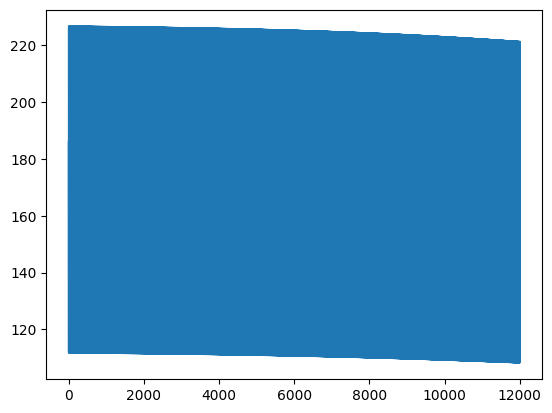

In [271]:
plt.plot(range(AE_EPOCHS * 6), losses)

In [272]:
losses

[186.02647399902344,
 170.0785369873047,
 152.66810607910156,
 125.66799926757812,
 111.83329010009766,
 226.61624145507812,
 186.0255584716797,
 170.0776824951172,
 152.66725158691406,
 125.66726684570312,
 111.8325424194336,
 226.61521911621094,
 186.0247344970703,
 170.076904296875,
 152.66641235351562,
 125.66656494140625,
 111.83177185058594,
 226.61431884765625,
 186.0238800048828,
 170.07603454589844,
 152.66555786132812,
 125.66585540771484,
 111.83100128173828,
 226.61322021484375,
 186.02308654785156,
 170.0752410888672,
 152.66468811035156,
 125.66513061523438,
 111.83025360107422,
 226.6122283935547,
 186.0222625732422,
 170.07435607910156,
 152.66383361816406,
 125.66444396972656,
 111.82947540283203,
 226.61097717285156,
 186.0213623046875,
 170.07351684570312,
 152.66299438476562,
 125.6637191772461,
 111.82872009277344,
 226.61000061035156,
 186.02053833007812,
 170.07266235351562,
 152.6621551513672,
 125.66300201416016,
 111.82795715332031,
 226.60897827148438,
 186.0

In [405]:
a = torch.from_numpy(np.array([0,1,0,0]))
b = torch.from_numpy(np.array([0.2,0.3,0.4,0.5]))

In [406]:
F.nll_loss(b,a)

tensor(-0.2000, dtype=torch.float64)